In [2]:
from collections import OrderedDict
import pickle

from ml_pee_stego_v3 import MLPEEStego

## Patient Data

In [ ]:
from utils.data_preparation import slice_batch_data, get_filenames_from_folder

# Tentukan folder path tempat secret
patient_folder_path = 'data/mit-bih-arrhythmia-database-1.0.0/'

# Dapatkan semua nama file .dat dari folder
patient_codes = get_filenames_from_folder('dat', patient_folder_path)
patient_codes.sort()

signals = []
for patient_code in patient_codes:
    batch_signals = slice_batch_data(patient_code=patient_code, max_batch=1)
    signals.extend(batch_signals)

print(len(signals))

In [3]:
from utils.data_preparation import get_original_data

patient_code = '100'
original_data = get_original_data(patient_code=patient_code)
len(original_data)

3600

## Secret File

In [4]:
from utils.data_preparation import get_secret_file

secret_filenames = ['secret_0.99_bps', 'secret_0.08_bps']

# Tentukan folder path tempat secret
SECRET_FOLDER_PATH = 'keys/bin'

# Masukkan ke dalam dictionary berisi nama filename beserta isi secret filenya
secret_dicts = OrderedDict((secret_filename, get_secret_file(
    SECRET_FOLDER_PATH + '/' + secret_filename + '.txt')) for secret_filename in secret_filenames)
# print(secret_dicts.get(secret_filenames[1]))

for secret_name, secret_data in secret_dicts.items():
    print(f"Secret untuk {secret_name}")

Secret untuk secret_0.99_bps
Secret untuk secret_0.08_bps


## Payload and Treshold

In [5]:
pr_n_t = [(1, 0), (3, 1)]

## Model

In [6]:
import warnings
from sklearn.exceptions import InconsistentVersionWarning

# Menonaktifkan peringatan InconsistentVersionWarning
warnings.simplefilter("ignore", category=InconsistentVersionWarning)

models = OrderedDict()

models['LASSO'] = 'models/lasso_model.pkl'

## Run

By secret

Secret[0]: secret_0.99_bps	0: pr(1) t(0)
[-145 -145 -145 -145 -145 -145 -145 -145 -119 -134]
Total yang kurang dari sama dengan threshold (T = 1): 598
Unhidden secret: 0
NCC: 0.9999928410383981
PRD: 0.17776591124822136
SNR: 55.00303033145307
PSNR: 31.73699339312499
Time: 0.9874870777130127
Axes(0.125,0.355;0.130341x0.1295)
Secret[0]: secret_0.99_bps	1: pr(3) t(1)
True
[-145 -145 -145 -145 -145 -145 -145 -145 -120 -136]
Total yang kurang dari sama dengan threshold (T = 1): 348
Unhidden secret: 0
NCC: 0.9999354743568334
PRD: 0.5337140242051783
SNR: 45.45382770503372
PSNR: 26.97592854225817
Time: 0.5401666164398193
Axes(0.547727,0.355;0.130341x0.1295)
Secret[1]: secret_0.08_bps	0: pr(1) t(0)
True
[-145 -145 -145 -145 -145 -145 -145 -145 -119 -135]
Total yang kurang dari sama dengan threshold (T = 1): 64
Unhidden secret: 0
NCC: 0.999999281054831
PRD: 0.056327284437289966
SNR: 64.98562371569005
PSNR: 36.72376853895371
Time: 0.09300684928894043
Axes(0.125,-0.065;0.130341x0.1295)
Secret[1]: s

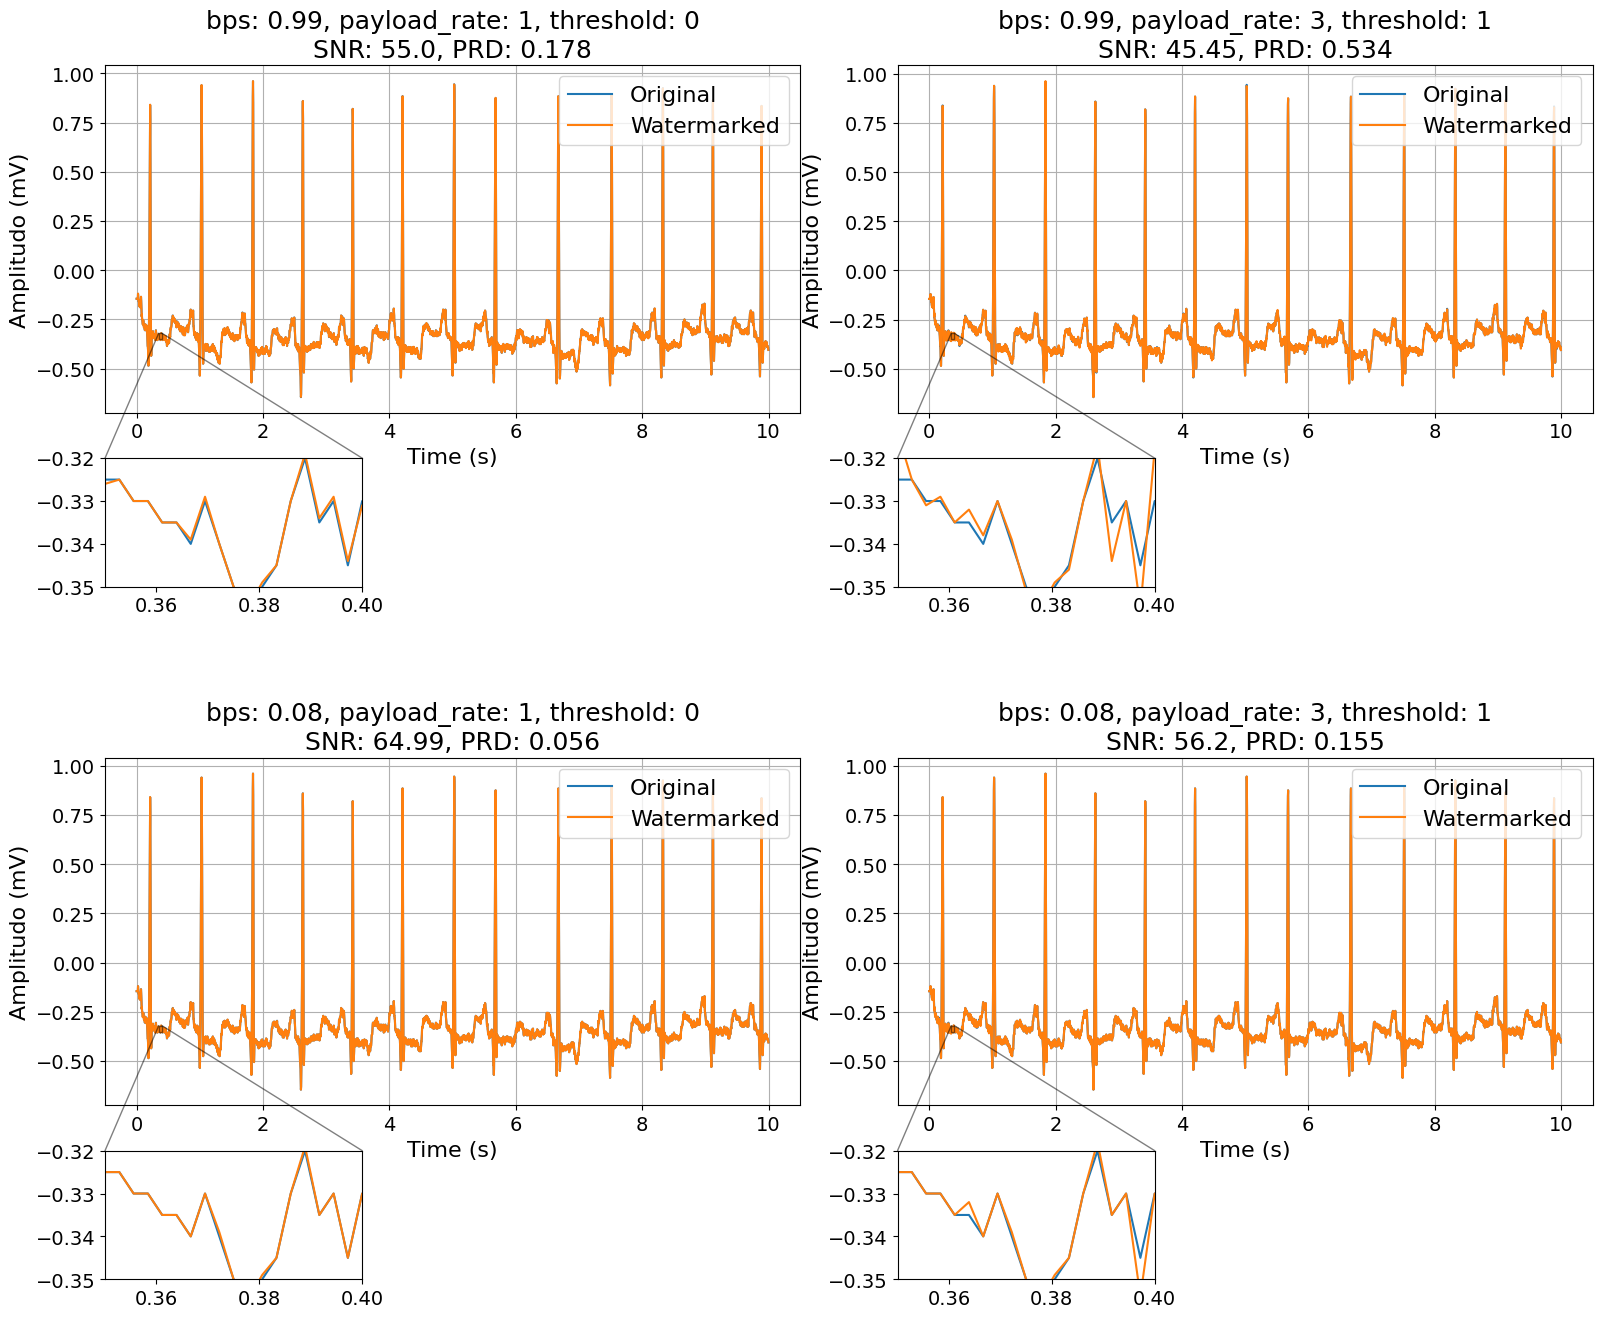

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset

model_name = 'LASSO'
with open(models.get(model_name), 'rb') as model_file:
    model = pickle.load(model_file)

stego = MLPEEStego(model)

fig, axs = plt.subplots(len(secret_dicts), len(pr_n_t), figsize=(16, 14))
names = ['a', 'b', 'c', 'd']

fs = 360
y = np.arange(len(original_data)) / fs

secret_index = 0
for secret_name, secret_data in secret_dicts.items():
    for pr_n_t_index, (payload_rate, threshold) in enumerate(pr_n_t):
        print(f'Secret[{secret_index}]: {secret_name}\t{pr_n_t_index}: pr({payload_rate}) t({threshold})')
        watermarked_data, _, _, _, _, result = stego.embed(
            original_data, secret_data, payload_rate=payload_rate, threshold=threshold)

        axs[secret_index, pr_n_t_index].plot(y, original_data/1000, label='Original')
        axs[secret_index, pr_n_t_index].plot(
            y, watermarked_data/1000, label='Watermarked')
        axs[secret_index, pr_n_t_index].set_xlabel('Time (s)', fontsize=16)
        axs[secret_index, pr_n_t_index].set_ylabel(
            'Amplitudo (mV)', fontsize=16)
        axs[secret_index, pr_n_t_index].set_title(
            f'bps: {secret_name[7:11]}, payload_rate: {payload_rate}, threshold: {threshold}\nSNR: {round(result.snr, 2)}, PRD: {round(result.prd, 3)}', 
            fontsize=18)
        axs[secret_index, pr_n_t_index].grid(True)
        axs[secret_index, pr_n_t_index].legend(loc='upper right', fontsize=16)
        axs[secret_index, pr_n_t_index].tick_params(axis='both', labelsize=14)

        # Buat sumbu tambahan yang diperbesar
        axins = axs[secret_index, pr_n_t_index].inset_axes(
            [0., -0.5, 0.37, 0.37],
            xlim=(0.35, 0.4), ylim=(-0.35, -0.32))
        axins.plot(y, original_data/1000)
        axins.plot(y, watermarked_data/1000)
        axins.tick_params(axis='both', labelsize=14)
        print(axins)
        axs[secret_index, pr_n_t_index].indicate_inset_zoom(axins, edgecolor="black")

    secret_index += 1

fig.tight_layout()
plt.savefig('out/v3_4_signal_comparison.png', dpi=300)
plt.show()

## Buku Tesis

Secret[0]: secret_0.99_bps	0: pr(1) t(0)
[-145 -145 -145 -145 -145 -145 -145 -145 -119 -134]
Total yang kurang dari sama dengan threshold (T = 1): 598
Unhidden secret: 0
NCC: 0.9999928410383981
PRD: 0.17776591124822136
SNR: 55.00303033145307
PSNR: 31.73699339312499
Time: 1.2294774055480957
Axes(0.125,0.355;0.130341x0.1295)
Secret[0]: secret_0.99_bps	1: pr(3) t(1)
True
[-145 -145 -145 -145 -145 -145 -145 -145 -120 -136]
Total yang kurang dari sama dengan threshold (T = 1): 348
Unhidden secret: 0
NCC: 0.9999354743568334
PRD: 0.5337140242051783
SNR: 45.45382770503372
PSNR: 26.97592854225817
Time: 0.653430700302124
Axes(0.547727,0.355;0.130341x0.1295)
Secret[1]: secret_0.08_bps	0: pr(1) t(0)
True
[-145 -145 -145 -145 -145 -145 -145 -145 -119 -135]
Total yang kurang dari sama dengan threshold (T = 1): 64
Unhidden secret: 0
NCC: 0.999999281054831
PRD: 0.056327284437289966
SNR: 64.98562371569005
PSNR: 36.72376853895371
Time: 0.0980081558227539
Axes(0.125,-0.065;0.130341x0.1295)
Secret[1]: sec

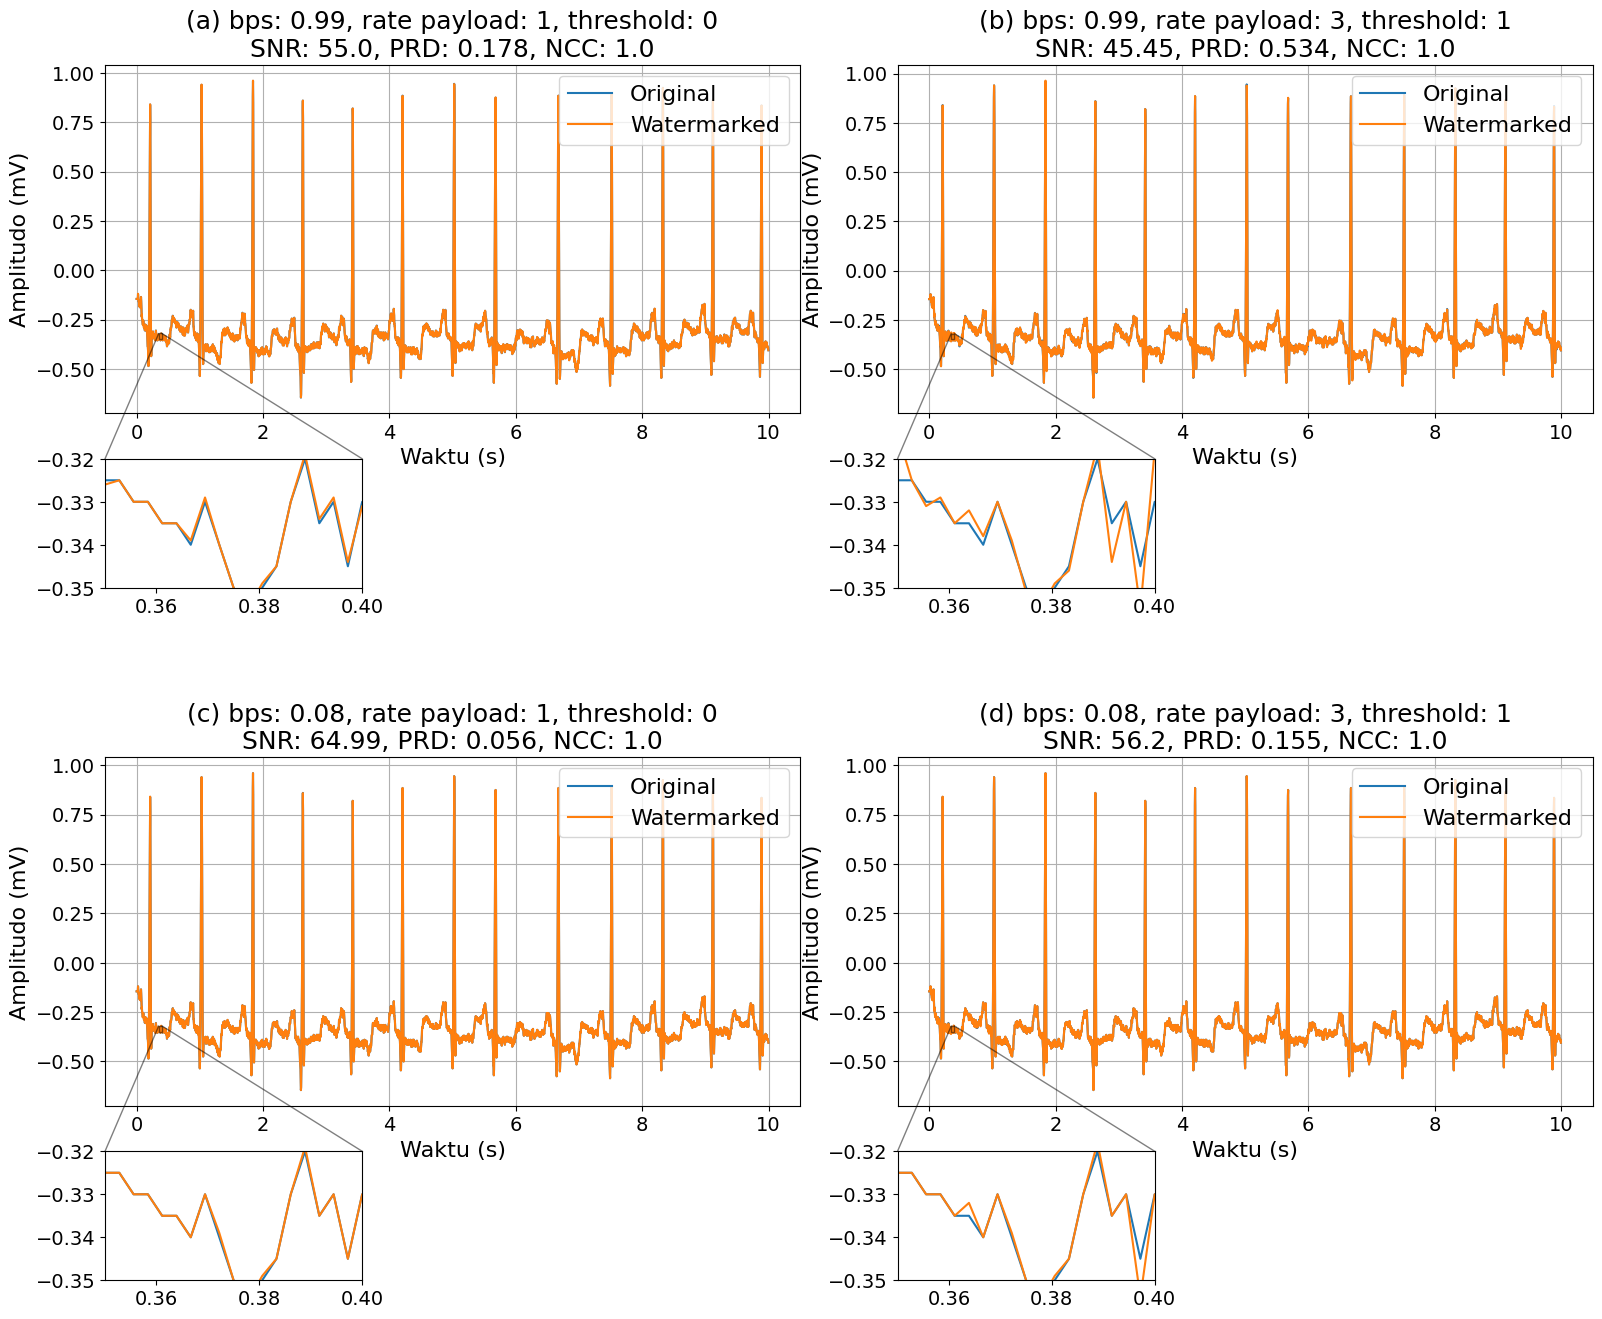

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset

model_name = 'LASSO'
with open(models.get(model_name), 'rb') as model_file:
    model = pickle.load(model_file)

stego = MLPEEStego(model)

fig, axs = plt.subplots(len(secret_dicts), len(pr_n_t), figsize=(16, 14))
names = ['a', 'b', 'c', 'd']

fs = 360
y = np.arange(len(original_data)) / fs

secret_index = 0
for secret_name, secret_data in secret_dicts.items():
    for pr_n_t_index, (payload_rate, threshold) in enumerate(pr_n_t):
        print(
            f'Secret[{secret_index}]: {secret_name}\t{pr_n_t_index}: pr({payload_rate}) t({threshold})')
        watermarked_data, _, _, _, _, result = stego.embed(
            original_data, secret_data, payload_rate=payload_rate, threshold=threshold)

        axs[secret_index, pr_n_t_index].plot(
            y, original_data/1000, label='Original')
        axs[secret_index, pr_n_t_index].plot(
            y, watermarked_data/1000, label='Watermarked')
        axs[secret_index, pr_n_t_index].set_xlabel('Waktu (s)', fontsize=16)
        axs[secret_index, pr_n_t_index].set_ylabel(
            'Amplitudo (mV)', fontsize=16)
        axs[secret_index, pr_n_t_index].set_title(
            f'({names[len(pr_n_t)*secret_index + pr_n_t_index]}) bps: {secret_name[7:11]}, rate payload: {payload_rate}, threshold: {threshold}\nSNR: {round(result.snr, 2)}, PRD: {round(result.prd, 3)}, NCC: {round(result.ncc, 3)}',
            fontsize=18)
        axs[secret_index, pr_n_t_index].grid(True)
        axs[secret_index, pr_n_t_index].legend(loc='upper right', fontsize=16)
        axs[secret_index, pr_n_t_index].tick_params(axis='both', labelsize=14)

        # Buat sumbu tambahan yang diperbesar
        axins = axs[secret_index, pr_n_t_index].inset_axes(
            [0., -0.5, 0.37, 0.37],
            xlim=(0.35, 0.4), ylim=(-0.35, -0.32))
        axins.plot(y, original_data/1000)
        axins.plot(y, watermarked_data/1000)
        axins.tick_params(axis='both', labelsize=14)
        print(axins)
        axs[secret_index, pr_n_t_index].indicate_inset_zoom(
            axins, edgecolor="black")

    secret_index += 1

fig.tight_layout()
plt.savefig('out/v3_4_signal_comparison_indo.png', dpi=300)
plt.show()